## Final Notebook

Please fill out:
* Group project 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


## Finding least risk prone genres

### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import sqlite3
import zipfile

### Importing the data

In [3]:
# Extract IMDb SQL .db file
with zipfile.ZipFile('./zippedData/im.db.zip') as zipObj:
    # Extract all contents of .zip file into current directory
    zipObj.extractall(path='./zippedData/')
    
# Create connection to IMDb DB
con = sqlite3.connect('./zippedData/im.db')


In [4]:
schema_df = pd.read_sql("""
        SELECT *
        FROM sqlite_master """, con)

In [5]:
# Understanding the structure of the database
schema_df

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [6]:
# Looking at movie_basics
pd.read_sql(""" 
            SELECT * 
            FROM movie_basics
            LIMIT 2
            """, con)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"


In [7]:
# Looking at movie_ratings
pd.read_sql(""" 
            SELECT *
            FROM movie_ratings
            LIMIT 2
            """, con)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559


In [8]:
# pulling movie_budgets csv
df_budget = pd.read_csv("zippedData/tn.movie_budgets.csv.gz")
df_budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


### Joining data

In [9]:
# inner joining movie_ratings and movie_basics in order to have access to ratings and genres in one table
df_combined = pd.read_sql(""" 
            SELECT *
            FROM movie_ratings
            JOIN movie_basics
            ON movie_basics.movie_id = movie_ratings.movie_id
            """, con)

In [10]:
# Checking missing values
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   averagerating    73856 non-null  float64
 2   numvotes         73856 non-null  int64  
 3   movie_id         73856 non-null  object 
 4   primary_title    73856 non-null  object 
 5   original_title   73856 non-null  object 
 6   start_year       73856 non-null  int64  
 7   runtime_minutes  66236 non-null  float64
 8   genres           73052 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 5.1+ MB


### Data cleaning

In [11]:
# Dropping missing values in genres column
df_combined.dropna(subset = ['genres'], inplace = True)

In [12]:
df_combined.head()

,movie_id,averagerating,numvotes,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt10356526,8.3,31,tt10356526,Laiye Je Yaarian,Laiye Je Yaarian,2019,117.0,Romance
1,tt10384606,8.9,559,tt10384606,Borderless,Borderless,2019,87.0,Documentary
2,tt1042974,6.4,20,tt1042974,Just Inès,Just Inès,2010,90.0,Drama
3,tt1043726,4.2,50352,tt1043726,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy"
4,tt1060240,6.5,21,tt1060240,Até Onde?,Até Onde?,2011,73.0,"Mystery,Thriller"


In [13]:
# replacing $ and , characters in production_budget column
df_budget.production_budget = df_budget.production_budget.str.replace('$','').str.replace(',','')

# casting to integer so we can filter based on production budget 
df_budget.production_budget = df_budget.production_budget.astype(int)
df_budget.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000,"$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,"$241,063,875","$1,045,663,875"


In [14]:
# slicing out high budget films in order to focus our analysis on high budget productions
df_high_budget = df_budget[df_budget.production_budget > 50000000]

In [15]:
# There are 16 different movies with the same title but different release date
df_high_budget[df_high_budget.duplicated(subset = ['movie'], keep = False) == True].sort_values('movie')

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
297,98,"Aug 7, 2015",Fantastic Four,120000000,"$56,117,548","$167,849,187"
484,85,"Jul 8, 2005",Fantastic Four,87500000,"$154,696,080","$333,132,750"
140,41,"May 16, 2014",Godzilla,160000000,"$200,676,069","$529,076,069"
273,74,"May 19, 1998",Godzilla,125000000,"$136,314,294","$376,000,000"
383,84,"Jul 25, 2014",Hercules,100000000,"$72,688,614","$243,388,614"
707,8,"Jun 13, 1997",Hercules,70000000,"$99,112,101","$250,700,000"
650,51,"Apr 16, 1999",Life,75000000,"$64,062,587","$73,521,587"
965,66,"Mar 24, 2017",Life,58000000,"$30,234,022","$100,929,666"
38,39,"May 14, 2010",Robin Hood,210000000,"$105,487,148","$322,459,006"
408,9,"Nov 21, 2018",Robin Hood,99000000,"$30,824,628","$84,747,441"


In [16]:
# Discovering that there are about 4 thousand of non unique titles in df_combined
len(df_combined.primary_title) - len(df_combined.primary_title.unique())

3804

In [17]:
#Creating column "title_year" in table df_combined: to use it to merge tables without unnecessary data loss
df_combined['title_year'] = df_combined.apply(lambda row: row.primary_title + " " + str(row.start_year), axis=1)

In [18]:
df_combined.head(2)

,movie_id,averagerating,numvotes,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,title_year
0,tt10356526,8.3,31,tt10356526,Laiye Je Yaarian,Laiye Je Yaarian,2019,117.0,Romance,Laiye Je Yaarian 2019
1,tt10384606,8.9,559,tt10384606,Borderless,Borderless,2019,87.0,Documentary,Borderless 2019


In [19]:
#Creating column "title_year" in table df_high_budget: to use it to merge tables without unnecessary data loss
df_high_budget['title_year'] = df_high_budget.apply(lambda row: row.movie + row.release_date[-5:], axis=1)

<ipython-input-19-9ceda84810bf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high_budget['title_year'] = df_high_budget.apply(lambda row: row.movie + row.release_date[-5:], axis=1)


In [20]:
#cleaning columns not needed from analysis
df_combined.drop(columns=['movie_id', 'original_title', 'primary_title', 'runtime_minutes', 'start_year'], axis=1, inplace = True)

In [21]:
#cleaning columns not needed from analysis
df_high_budget.drop(columns=['id', 'release_date'], inplace = True)

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [22]:
# Casting string type to title_year
df_combined.title_year = df_combined.title_year.astype(str)
df_high_budget.title_year = df_high_budget.title_year.astype(str)

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [23]:
#Merging Budget and Combined tables to have access to all the data in one table
df_newdata = pd.merge(df_combined, df_high_budget, how = 'inner', on='title_year')

In [24]:
df_newdata.head(2)

,averagerating,numvotes,genres,title_year,movie,production_budget,domestic_gross,worldwide_gross
0,4.2,50352,"Action,Adventure,Fantasy",The Legend of Hercules 2014,The Legend of Hercules,70000000,"$18,848,538","$58,953,319"
1,4.4,69199,"Comedy,Drama,Romance",Sex and the City 2 2010,Sex and the City 2,95000000,"$95,347,692","$294,680,778"


In [25]:
#Filtering movies with the rating lower than median of the dataset. The analysis is focused on 
# the performance of low rating films.
low_ranking = df_newdata[df_newdata['averagerating'] < df_newdata['averagerating'].median()]

In [26]:
#Eliminating films with low review count in order to focus on ratings substantiated by the review count.
low_ranking = low_ranking[low_ranking['numvotes'] > 1000]

In [27]:
# Finding unique genres identifiers
genres_list = list(low_ranking.genres.unique())
newlst = []
for i in genres_list:
    
    newlst.extend(i.split(','))
unique_genres = list(set(newlst))
unique_genres

['Comedy',
 'Mystery',
 'Sci-Fi',
 'Western',
 'War',
 'Animation',
 'Thriller',
 'Music',
 'Adventure',
 'History',
 'Fantasy',
 'Musical',
 'Family',
 'Action',
 'Sport',
 'Horror',
 'Crime',
 'Romance',
 'Drama']

In [28]:
#converting column genres into a list of genre identifiers
low_ranking['genres'] = low_ranking.apply(lambda row: row.genres.split(','), axis=1)

In [29]:
#Exploding column with multiple genre identifiers into rows with single genre identifiers
low_ranking = low_ranking.explode('genres')

In [30]:
low_ranking.count()

averagerating        516
numvotes             516
genres               516
title_year           516
movie                516
production_budget    516
domestic_gross       516
worldwide_gross      516
dtype: int64

In [31]:
#converting gross columns into integer datatype
low_ranking.domestic_gross = low_ranking.domestic_gross.str.replace('$','').str.replace(',','')
# replacing $ and , characters in production_budget column
low_ranking.worldwide_gross = low_ranking.worldwide_gross.str.replace('$','').str.replace(',','')

# casting to integer so we can filter based on production budget is 
low_ranking.domestic_gross = low_ranking.domestic_gross.astype(int)
low_ranking.worldwide_gross = low_ranking.worldwide_gross.astype(int)

In [32]:
#Sanity check
low_ranking.head(2)

,averagerating,numvotes,genres,title_year,movie,production_budget,domestic_gross,worldwide_gross
0,4.2,50352,Action,The Legend of Hercules 2014,The Legend of Hercules,70000000,18848538,58953319
0,4.2,50352,Adventure,The Legend of Hercules 2014,The Legend of Hercules,70000000,18848538,58953319


In [33]:
# ROI is calculated by subtracting the beginning value from the current value 
# and then dividing the number by the beginning value.
# https://www.investopedia.com/terms/r/returnoninvestment.asp

low_ranking['roi'] = (low_ranking['worldwide_gross'] - low_ranking['production_budget'])/low_ranking['production_budget']


,averagerating,numvotes,genres,title_year,movie,production_budget,domestic_gross,worldwide_gross,roi
0,4.2,50352,Action,The Legend of Hercules 2014,The Legend of Hercules,70000000,18848538,58953319,-0.157810
0,4.2,50352,Adventure,The Legend of Hercules 2014,The Legend of Hercules,70000000,18848538,58953319,-0.157810
0,4.2,50352,Fantasy,The Legend of Hercules 2014,The Legend of Hercules,70000000,18848538,58953319,-0.157810
1,4.4,69199,Comedy,Sex and the City 2 2010,Sex and the City 2,95000000,95347692,294680778,2.101903
1,4.4,69199,Drama,Sex and the City 2 2010,Sex and the City 2,95000000,95347692,294680778,2.101903


In [34]:
# Creating profit column
low_ranking['profit'] = (low_ranking['worldwide_gross'] - low_ranking['production_budget'])

### Analysis and visualization

In [ ]:
# Romance stands out with negative correlation between rating and worldwide gross as well as ROI, and profit metrics.

Text(0.5, 0, 'RATING')

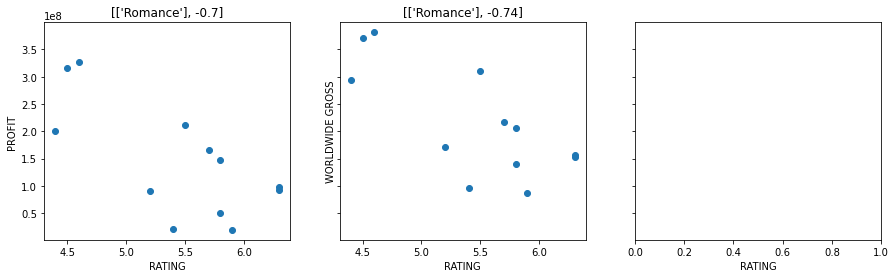

In [39]:
# Need to put them on 3 different scatterplots (ROI worldwide, Worldwide gross, Profit)
# and draw a regression line

# plt.savefig(‘/my_plot.png')

figure, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 4), nrows=1, ncols=3, sharey = True)
scatter_plot_title = ['Romance']
ax1.scatter(x= 'averagerating', y= 'profit', data = low_ranking[low_ranking['genres'] == 'Romance'])
ax1.set_title([scatter_plot_title, low_ranking[low_ranking.genres=='Romance'].corr().loc['profit'][0].round(2)])
ax1.set_ylabel('PROFIT')
ax1.set_xlabel('RATING')

ax2.scatter(x= 'averagerating', y= 'worldwide_gross', data = low_ranking[low_ranking['genres'] == 'Romance'])
ax2.set_title([scatter_plot_title, low_ranking[low_ranking.genres=='Romance'].corr().loc['worldwide_gross'][0].round(2)])
ax2.set_ylabel('WORLDWIDE GROSS')
ax2.set_xlabel('RATING')

# ax3.scatter(x= 'averagerating', y= 'roi', data = low_ranking[low_ranking['genres'] == 'Romance'])
# ax3.set_title([scatter_plot_title, low_ranking[low_ranking.genres=='Romance'].corr().loc['roi'][0].round(2)])
# ax3.set_ylabel('ROI')
ax3.set_xlabel('RATING')

In [246]:
low_ranking[low_ranking.genres=='Romance'].corr().loc['averagerating'].sort_values().round(2)
# .loc['profit'][0].round(2)

worldwide_gross     -0.74
profit              -0.70
roi                 -0.60
domestic_gross      -0.36
production_budget   -0.16
numvotes             0.81
averagerating        1.00
Name: averagerating, dtype: float64

In [178]:
low_ranking[low_ranking.genres=='Romance'].corr().loc['profit'][0].round(2)

-0.7

In [241]:
unique_genres

['War',
 'Animation',
 'Thriller',
 'Action',
 'Mystery',
 'Romance',
 'Crime',
 'Sport',
 'Western',
 'Fantasy',
 'Musical',
 'Drama',
 'Family',
 'Horror',
 'Sci-Fi',
 'Adventure',
 'History',
 'Music',
 'Comedy']